# Ornstein Uhlenbeck calibration by MCMC

The goal is to estimate the parameters of an Ornstein Uhlenbeck model. To do this we will:
+ Implement the Likelihood Function of the OU model : $L(\alpha, \beta, \gamma, x_{t_1}, x_{t_2}, ..., x_{t_n})$
+ Extract data from the simulations implemented in OU_sumulation.ipynb: $x_{t_1}, x_{t_2}, ..., x_{t_n}$
+ Estimate the parameters of the simulation Using an MCMC optimization algorithm

### Likelihood Function

The Ornstein Uhlenbeck process is a Markov Chain. For a sample path $x_0, x_{\frac{T}{N}}, x_{\frac{2T}{N}}, ..., x_T$, the likelihood function is then equal to:

$$L(\alpha, \beta, \gamma, x_0, x_{\frac{T}{N}}, x_{\frac{2T}{N}}, ..., x_T) = \prod_{k=0}^{N-1}{f(x_{\frac{(k+1)T}{N}} | x_{\frac{kT}{N}})}$$
where $f$ is the conditional probability density function of the process.

Given $X_{\frac{kT}{N}}$, the value of the Ornstein Uhlenbeck process at time $\frac{kT}{N}$, $X_{\frac{(k+1)T}{N}}$ is normally distributed with:

$$E(X_{\frac{(k+1)T}{N}} | X_{\frac{kT}{N}}) = X_{\frac{kT}{N}}e^{-\alpha T/N} + \gamma(1-e^{-\beta T/N})$$

$$ Var(X_{\frac{(k+1)T}{N}} | X_{\frac{kT}{N}}) = \frac{\beta^2}{2\alpha}(1-e^{-2\alpha T/N}) $$

Let's denote $E_k$ the previous expectation and $V$ the previous variance (doesn't depend on k). The likelihood function over a sample path $x_0, x_{\frac{T}{N}}, x_{\frac{2T}{N}}, ..., x_T$ of the Ornstein Uhlenbeck process is then equal to:

$$\prod_{k=0}^{N-1}{\frac{1}{\sqrt{2\pi V}} e^{-\frac{(x_{(k+1)T/N} - E_k)^2}{2V}}}$$

Consequently, the negative log likelihood is equal to:

$$NLL(\alpha, \beta, \gamma) = \sum_{k=0}^{N-1}{\frac{(x_{(k+1)T/N} - E_k)^2}{2V} + ln(2\pi V)/2 }$$

which we will minimize to find the parameters $\alpha$, $\beta$ and $\gamma$.

In [88]:
from utils import *

import matplotlib.pyplot as plt
from numpy import exp, log, pi
import numpy as np

def likelihood(T, N, alpha, beta, gamma, path):
    h = T/N
    exp_alpha_h = exp(-alpha*h)
    if type(alpha) is int and alpha == 0:
        V = h*beta**2
    else:
        V = (beta**2)*(1-exp_alpha_h**2)/(2*alpha)
        
    ans = N*log(2*pi*V)/2
    for k in range(N):
        Ek = path[k]*exp_alpha_h + gamma*(1-exp_alpha_h)
        ans += ((path[k+1] - Ek)**2)/(2*V)
    return ans


### Class for the parameters

In [89]:
class OU_Parameters:
    def __init__(self,alpha,beta,gamma) -> None:
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
    
    def __str__(self) -> str:
        s ='\n==== OU Parameters ====\n'
        s+='   alpha : '+str(self.alpha)+'\n'
        s+='   beta  : '+str(self.beta)+'\n'
        s+='   gamma : '+str(self.gamma)+'\n'
        s+='==== OU Parameters ====\n'+'\n'
        return s

### Defintion of the boundaries

In [90]:
minParams = OU_Parameters(alpha=0,beta=1,gamma=1)
maxParams = OU_Parameters(alpha=0.1,beta=3,gamma=5)

# alphaBoundaries = (0 , 0.1)
# betaBoundaries  = (1 , 3  )
# gammaBoundaries = (1 , 5  )

### Code for estimation plot

In [91]:
def estimation_plot(T,N,x0,params,traceParams,paramToPlot):
    path = OU_process(T, N, x0, params.alpha, params.beta, params.gamma)

    if paramToPlot == 'alpha':
        NLL = likelihood(T, N, traceParams, params.beta, params.gamma, path)
    elif paramToPlot == 'beta':
        NLL = likelihood(T, N, params.alpha, traceParams, params.gamma, path)
    elif paramToPlot == 'gamma':
        NLL = likelihood(T, N, params.alpha, params.beta, traceParams, path)
        
    plt.plot(traceParams, NLL)

### Estimating $\alpha$
+ $x_0$ should be far from $\gamma$

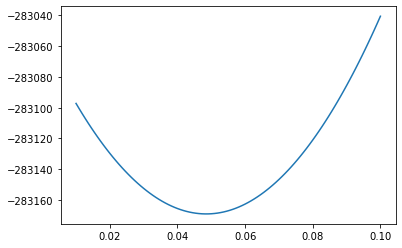

In [92]:
estimation_plot(
    T = 50, 
    N = 100000, 
    x0 = 100,
    params = OU_Parameters(alpha=0.05,beta = 1,gamma = 3),
    traceParams = np.linspace(0.01, 0.1, 100),
    paramToPlot='alpha')

### Estimating $\beta$
+ $T$ should be small (to focus on the first steps of the process)
+ $\beta > 0$ 

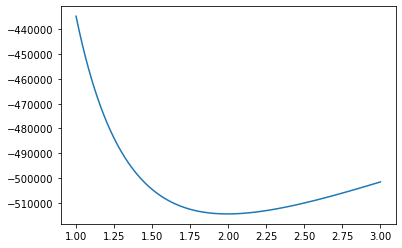

In [93]:
beta = 2
estimation_plot(
    T = 0.05, 
    N = 100000, 
    x0 = 100,
    params = OU_Parameters(alpha=0.05,beta = beta,gamma = 0),
    traceParams = np.linspace(beta-1, beta + 1,100),
    paramToPlot='beta')

### Estimating $\gamma$
+ $T$ should be large enough, to allow the process to converge to $\gamma$

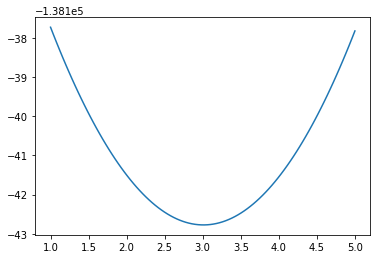

In [94]:
gamma = 3
estimation_plot(
    T = 1000, 
    N = 100000, 
    x0 = 0,
    params = OU_Parameters(alpha=0.05,beta = 1,gamma = gamma),
    traceParams = np.linspace(gamma-2, gamma+2, 100),
    paramToPlot='gamma')

### Likelihood over $\alpha$ and $\beta$

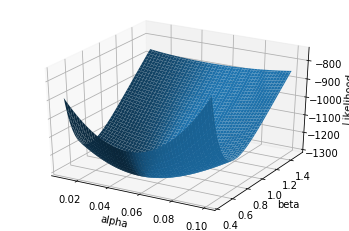

In [95]:
from mpl_toolkits.mplot3d import Axes3D

minParams = OU_Parameters(alpha=0.01,beta=0.45,gamma=1)
maxParams = OU_Parameters(alpha=0.1,beta=1.5,gamma=5)
paramsToFind = OU_Parameters(alpha=0.05,beta=1,gamma=3.7)

n = 100
x0 = 100
N = 1000
T = 10
alphas = np.linspace(minParams.alpha, maxParams.alpha, n)
betas = np.linspace(minParams.beta, maxParams.beta, n)
gamma = paramsToFind.gamma
path = OU_process(T, N, x0, paramsToFind.alpha, paramsToFind.beta, paramsToFind.gamma)

As, Bs = np.meshgrid(alphas, betas)
Ls = likelihood(T, N, As, Bs, gamma, path)
ax = plt.figure().gca(projection='3d')
ax.set_xlabel("alpha")
ax.set_ylabel("beta")
ax.set_zlabel("Likelihood")

ax.plot_surface(As, Bs, Ls)


### Likelihood over $\alpha$ and $\gamma$

d:\Users\fadel\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
d:\Users\fadel\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Z contains NaN values. This may result in rendering artifacts.


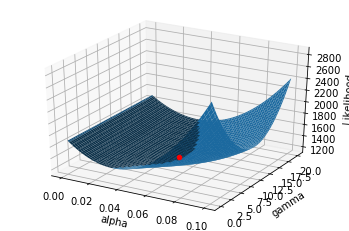

In [96]:
minParams = OU_Parameters(alpha=0,beta=0.45,gamma=0)
maxParams = OU_Parameters(alpha=0.1,beta=1.5,gamma=20)
paramsToFind = OU_Parameters(alpha=0.05,beta=1,gamma=10)

n = 100
x0 = 200
N = 1000
T = 2000
alphas = np.linspace(minParams.alpha, maxParams.alpha, n)
beta = paramsToFind.beta
gammas = np.linspace(minParams.gamma, maxParams.gamma, n)
path = OU_process(T, N, x0, paramsToFind.alpha, paramsToFind.beta, paramsToFind.gamma)

As, Gs = np.meshgrid(alphas, gammas)
Ls = likelihood(T, N, As, beta, Gs, path)
ax = plt.figure().gca(projection='3d')
ax.set_xlabel("alpha")
ax.set_ylabel("gamma")
ax.set_zlabel("Likelihood")
ax.plot_surface(As, Gs, Ls)
ax.scatter([paramsToFind.alpha], [paramsToFind.gamma], 
            [likelihood(T, N, paramsToFind.alpha, paramsToFind.beta, paramsToFind.gamma, path)], 
            color="red")

## Estimating all parameters with Metropolis-Hastings

### Definition of the Markov transition in 3D

In [40]:
import random 
def MarkovTransition(param): 
    r = random.random()
    alpha1 = max(minParams.alpha,min(maxParams.alpha,param.alpha + 2*(r-0.5)*(maxParams.alpha-minParams.alpha)/100))  # uniform distribution on [alpha - alphaBoundaries/10;alpha + alphaBoundaries/10]
    r = random.random()
    beta1 = max(minParams.beta,min(maxParams.beta,param.beta + 2*(r-0.5)*(maxParams.beta-minParams.beta)/100))
    r = random.random()
    gamma1 = max(minParams.gamma,min(maxParams.gamma,param.gamma + 2*(r-0.5)*(maxParams.gamma-minParams.gamma)/100))
    return OU_Parameters(alpha1,beta1,gamma1)

### Metropolis Hastings algorithm

In [41]:
from tqdm import tqdm
from math import inf

def OU_metropolis_mcmc(n,T,N,path,Xs=None):
    if Xs is None:
        Xs = OU_Parameters(  alpha = minParams.alpha + random.random()*(maxParams.alpha-minParams.alpha),
                        beta = minParams.beta + random.random()*(maxParams.beta-minParams.beta) ,
                        gamma = minParams.gamma + random.random()*(maxParams.gamma-minParams.gamma))
    
    BestX = None
    bestNLL = inf
    samples = [Xs]
    NLLs = [likelihood(T,N,Xs.alpha,Xs.beta,Xs.gamma,path)]

    for _ in tqdm(range(n)):
        xi = samples[-1]
        x = MarkovTransition(xi)
        NLL = likelihood(T,N,x.alpha,x.beta,x.gamma,path)
        alpha = NLLs[-1]/NLL #since we want NLL < NLL[-1]
        if NLL<bestNLL:
            bestNLL=NLL,
            BestX=xi
        u = random.random()
        if u < alpha:
            samples.append(x)
            NLLs.append(NLL)
        else:
            samples.append(xi)
            NLLs.append(NLLs[-1])
    return samples,NLLs,BestX,bestNLL

## Distribution estimation 

In [42]:

paramsToFind = OU_Parameters(alpha=0.04,beta=1.75,gamma=3.7)

samples1,NLLs1,BestX1,NLL1 = OU_metropolis_mcmc(n    = 10**5,
                                                T    = 1000,
                                                N    = 1000,
                                                # Xs   = paramsToFind,
                                                path = OU_process(  T     = 1000,
                                                                    N     = 10000,
                                                                    x0    = 100, 
                                                                    alpha = paramsToFind.alpha,
                                                                    beta  = paramsToFind.beta,
                                                                    gamma = paramsToFind.gamma))


100%|██████████| 100000/100000 [00:37<00:00, 2671.13it/s]


In [43]:
print('Expected parameters')
print(paramsToFind)
print('Estimated parameters')
print(BestX1)

Expected parameters

==== OU Parameters ====
   alpha : 0.04
   beta  : 1.75
   gamma : 3.7
==== OU Parameters ====


Estimated parameters

==== OU Parameters ====
   alpha : 0.003498149815315188
   beta  : 1.0051333962538633
   gamma : 3.8623077300961373
==== OU Parameters ====




### 3D visualisation of the Markov chain path

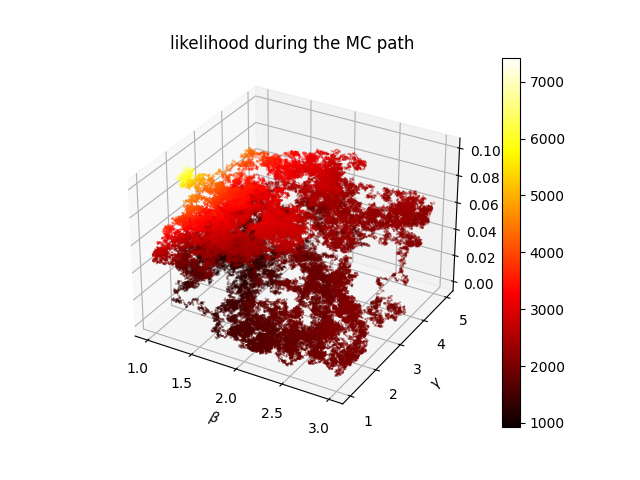

In [44]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')

imax = 100000

zline = [s.alpha for s in samples1][:imax]
xline = [s.beta for s in samples1][:imax]
yline = [s.gamma for s in samples1][:imax]
color = NLLs1[:imax]

img = ax.scatter(xline,yline,zline,c=color,cmap='hot',s=0.1)

ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\gamma$')
ax.set_zlabel(r'$\alpha$')

ax.scatter(BestX1.beta,BestX1.gamma,BestX1.alpha, c='green',marker='+',s=100)

plt.title('likelihood during the MC path')
plt.colorbar(img)
plt.show()



## Meta MCMC finder
We could use multiprocessing to accelerate the multi MCMC search

In [45]:
paramsToFind = OU_Parameters(alpha=0.04,beta=1.75,gamma=3.7)

sampless,NLLss,bestXs,NLLlist=[],[],[],[]
for posT in [1,1000]:
    for posx0 in [0,100]:
        #region MCMC calculation
        samples,NLLs,BestX,NLL = OU_metropolis_mcmc(n    = 10**5,
                                                    T    = posT,
                                                    N    = 1000,
                                                    path = OU_process(  T     = posT,
                                                                        N     = 10000,
                                                                        x0    = posx0, 
                                                                        alpha = paramsToFind.alpha,
                                                                        beta  = paramsToFind.beta,
                                                                        gamma = paramsToFind.gamma))
        #endregion
        
        sampless.append(samples)
        NLLss.append(NLLs)
        bestXs.append(BestX)
        NLLlist.append(NLL)

newBestNLL = min(NLLlist) #difficult to compare bc the likelihood path and T are not the same, so it is not the same function
newBestX = bestXs[NLLlist.index(newBestNLL)]


100%|██████████| 100000/100000 [00:36<00:00, 2743.39it/s]


In [46]:
for x in bestXs[::-1]:
    print(x)


==== OU Parameters ====
   alpha : 0.0035210830863497524
   beta  : 1.0052858713061072
   gamma : 4.987747140250998
==== OU Parameters ====



==== OU Parameters ====
   alpha : 0.04081976984779175
   beta  : 1.0018510047896012
   gamma : 1.1829300995112542
==== OU Parameters ====



==== OU Parameters ====
   alpha : 0.007515116545477913
   beta  : 1.0039258106405302
   gamma : 2.117942200432878
==== OU Parameters ====



==== OU Parameters ====
   alpha : 0.04853350359566201
   beta  : 1.3619616076130372
   gamma : 3.4303101609071223
==== OU Parameters ====


